---
### Initial Configurations

In [1]:
import os
import networkx as nx
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

from parsers import vulnerability_parser, attack_graph_parser, topology_parser
from compose_generator import generate_full_conn
from mio import wrapper

argv=['', 'designed/atsea']
stat, config, examples, times = wrapper.init(argv)
assert stat == 0

t_executor = ThreadPoolExecutor()
attack_vectors = vulnerability_parser.get_attack_vectors(config["attack-vector-folder-path"], t_executor)
example_folder, result_folder = wrapper.create_folders(argv[1], config)

Reading NVD feed file: nvdcve-1.0-2007.json
Reading NVD feed file: nvdcve-1.0-2011.json
Reading NVD feed file: nvdcve-1.1-2021.json
Reading NVD feed file: nvdcve-1.1-2020.json
Reading NVD feed file: nvdcve-1.0-2010.json
Reading NVD feed file: nvdcve-1.0-2006.json
Reading NVD feed file: nvdcve-1.0-modified.json
Reading NVD feed file: nvdcve-1.0-2017.json
Reading NVD feed file: nvdcve-1.0-2016.json
Reading NVD feed file: nvdcve-1.0-2015.json
Reading NVD feed file: nvdcve-1.0-2003.json
Reading NVD feed file: nvdcve-1.0-2002.json
Reading NVD feed file: nvdcve-1.1-modified.json
Reading NVD feed file: nvdcve-1.0-2014.json
Reading NVD feed file: nvdcve-1.0-2018.json
Reading NVD feed file: nvdcve-1.0-2013.json
Reading NVD feed file: nvdcve-1.1-2019.json
Reading NVD feed file: nvdcve-1.0-2005.json
Reading NVD feed file: nvdcve-1.0-2009.json
Reading NVD feed file: nvdcve-1.0-2008.json
Reading NVD feed file: nvdcve-1.0-2004.json
Reading NVD feed file: nvdcve-1.0-2012.json
Reading NVD feed file: n

---
### Parsing the topology of docker-compose file

In [24]:
networks, services, gateway_nodes, dt = topology_parser.parse_topology(example_folder)

networks: dict[str, dict[str, set]]
services: dict[str, dict[str, ]]
gateway_nodes: set[str]

Topology parsing started.
Time for parsing topology: 0.007607936859130859 seconds.


---
### create topology in format of dictionary of lists

In [25]:
topology_graph, gateway_graph, gateway_graph_labels, dg = topology_parser.create_graphs(networks, services)

topology_graph: nx.Graph
gateway_graph: nx.Graph
gateway_graph_labels: dict[(str, str), str]

print('\nTime for generating topology:', dt + dg, 'seconds.')

Topology graph creation started.
Time for creating topology graphs: 0.00030684471130371094 seconds.

Time for generating topology: 0.00791478157043457 seconds.


---
### Parsing the vulnerabilities for each docker container

In [26]:
stat, vulnerabilities, parsed_images, dv = vulnerability_parser.parse_vulnerabilities(example_folder, services)

assert stat == 0

vulnerabilities: dict[str, dict[str, ]]
parsed_images: set[str]

Getting vulnerabilities in services started.
Time for getting vulnerabilities in services: 0.023573875427246094 seconds.


---
### Merging the attack vector files and creating an attack vector dictionary.

In [27]:
exploitable_vulnerabilities, dvp = vulnerability_parser.get_exploitable_vulnerabilities(
    services, vulnerabilities, config["preconditions-rules"], config["postconditions-rules"], attack_vectors)

exploitable_vulnerabilities: dict[str, dict[str, dict[str, int]]]

print('\nTime for vulnerability parser module:', dv + dvp, 'seconds.')

Pre-processing vulnerabilities started.
Total 62 vulnerabilities in service reverse_proxy
Total 110 vulnerabilities in service database
Total 10 vulnerabilities in service appserver
Total 138 vulnerabilities in service payment-db
Total 62 vulnerabilities in service payment_gateway
Time for vulnerabilities pre-processing: 0.01599407196044922 seconds.

Time for vulnerability parser module: 0.03956794738769531 seconds.


---
### Getting the attack graphs for each network

In [ ]:
executor = ProcessPoolExecutor()

attack_graph, graph_labels, da = attack_graph_parser.\
    generate_attack_graph(networks, services, exploitable_vulnerabilities, executor)

attack_graph: dict[str, nx.DiGraph]
graph_labels: dict[str, dict[(str, str), str]]

---
### composing attack graphs

In [ ]:
composed_graph, composed_labels, dcg = attack_graph_parser.get_graph_compose(attack_graph, graph_labels)

composed_graph: nx.DiGraph
composed_labels: dict[(str, str), str]

print('\nTime for attack graph generating module:', da + dcg, 'seconds.')

---
### print summaries

In [ ]:
wrapper.print_summary(topology_graph.number_of_nodes(),
                      topology_graph.number_of_edges(),
                      composed_graph.number_of_nodes(),
                      composed_graph.number_of_edges())

---
### change result folders

In [ ]:
times += 1

---
### draw topology graph

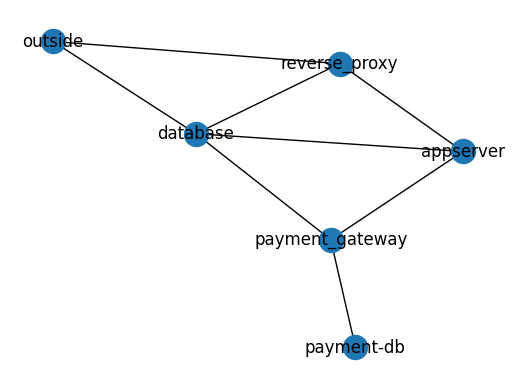

In [28]:
plt.axis("off")
pos = nx.spring_layout(topology_graph)
nx.draw_networkx_nodes(topology_graph, pos)
nx.draw_networkx_edges(topology_graph, pos)
nx.draw_networkx_labels(topology_graph, pos)
plt.show()

In [ ]:
topology_graph_folder = os.path.join(result_folder, str(times))
topology_graph_path = os.path.join(topology_graph_folder, 'topology-graph.png')
plt.savefig(topology_graph_path, transparent=True)

---
### draw gateway graph

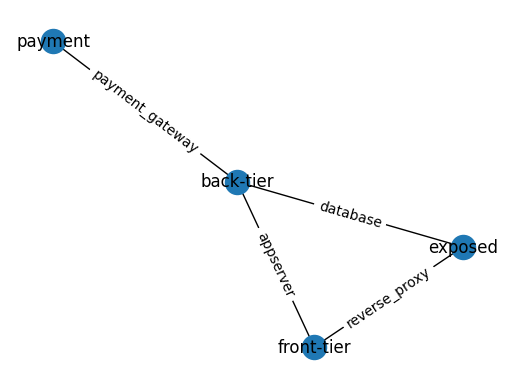

In [29]:
plt.axis("off")
pos = nx.spring_layout(gateway_graph)
nx.draw_networkx_nodes(gateway_graph, pos)
nx.draw_networkx_edges(gateway_graph, pos)
nx.draw_networkx_labels(gateway_graph, pos)
nx.draw_networkx_edge_labels(gateway_graph, pos, edge_labels=gateway_graph_labels)
plt.show()

In [ ]:
gateway_graph_folder = os.path.join(result_folder, str(times))
gateway_graph_path = os.path.join(gateway_graph_folder, 'gateway-graph.png')
plt.savefig(gateway_graph_path, transparent=True)

---
### Draw attack graph

In [ ]:
plt.axis("off")
pos = nx.spring_layout(composed_graph)
nx.draw_networkx_nodes(composed_graph, pos)
nx.draw_networkx_edges(composed_graph, pos)
nx.draw_networkx_labels(composed_graph, pos)
nx.draw_networkx_edge_labels(composed_graph, pos, edge_labels=composed_labels)
plt.show()

---
### generate example folders of full connections

In [ ]:
x = list(range(50, 1001, 50))
x.append([1, 5, 10])
for j in x:
    generate_full_conn(j)

add container to a network

name = 'test'
image = 'nginx'
network = ['db', 'backend']

wrappers.add_node(name, image, network, vulnerabilities, parsed_images, example_folder, networks, topology,
         topology_graph, services, mapping_names, attack_vector_dict, config, nodes, edges,
         passed_nodes, passed_edges, attack_graph)


delete container by name

name = 'test'
wrappers.del_node(name, networks, topology, services, mapping_names, nodes, edges, passed_nodes, passed_edges, attack_graph)


add honeypot nodes


to = 'goal'
minimum = 3

path_counts = wrappers.gen_defence_list(attack_graph, to)
wrappers.deploy_honeypot(path_counts, minimum, vulnerabilities, parsed_images, example_folder, networks,
                         topology, topology_graph, services, mapping_names, attack_vector_dict, config,
                         nodes, edges, passed_nodes, passed_edges, attack_graph)